<a href="https://colab.research.google.com/github/ioannis-toumpoglou/pytorch-repo/blob/main/Detectron2_with_Custom_COCO_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install Detectron2
!pip install -U torch torchvision
!pip install git+https://github.com/facebookresearch/fvcore.git
!git clone https://github.com/facebookresearch/detectron2 detectron2_repo
!pip install -e detectron2_repo

  Cloning https://github.com/facebookresearch/fvcore.git to /tmp/pip-req-build-gq68cjhy
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/fvcore.git /tmp/pip-req-build-gq68cjhy
  Resolved https://github.com/facebookresearch/fvcore.git to commit d817f01ca43612daa3923332beafb5a113148489
  Preparing metadata (setup.py) ... done
  Created wheel for fvcore: filename=fvcore-0.1.6-py3-none-any.whl size=65299 sha256=ab6ea2cfdfb0d5758ea2403a670eff3e8bb13ca031169780f3586c910d81957a
  Stored in directory: /tmp/pip-ephem-wheel-cache-yv5wjbyw/wheels/8f/cb/6a/3b7ac0e01781855ca3d1417ebf9e15e20d5b7fe37ab063aa50
Successfully built fvcore
  Attempting uninstall: fvcore
    Found existing installation: fvcore 0.1.5.post20221221
    Uninstalling fvcore-0.1.5.post20221221:
      Successfully uninstalled fvcore-0.1.5.post20221221
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of 

In [2]:
# Create data directory
from pathlib import Path


data_path = Path('data/')
image_path = data_path / 'images'

if image_path.is_dir():
  print(f'[INFO] {image_path} already exists, skipping download...')
else:
  print(f'[INFO] Unable to find {image_path}, creating one...')
  image_path.mkdir(parents=True, exist_ok=True)

[INFO] data/images already exists, skipping download...


In [3]:
from detectron2.data.datasets import register_coco_instances


register_coco_instances("emergency_exit_sign", {}, "./data/annotations.json", "./data")

In [4]:
from detectron2.data import DatasetCatalog, MetadataCatalog

dataset_dicts = DatasetCatalog.get("emergency_exit_sign")
emergency_exit_sign_metadata = MetadataCatalog.get("emergency_exit_sign")

Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.



In [5]:
!pip install opencv-python

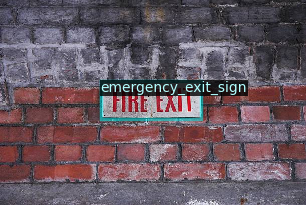

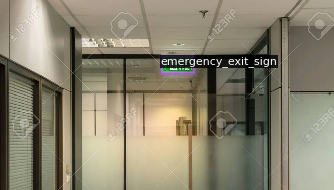

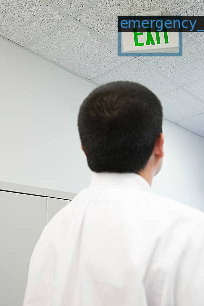

In [6]:
# Verify that data loading is correct
import random
from detectron2.utils.visualizer import Visualizer
import cv2
from google.colab.patches import cv2_imshow

for d in random.sample(dataset_dicts, 3):
  img = cv2.imread(d["file_name"])
  visualizer = Visualizer(img[:, :, ::-1], metadata=emergency_exit_sign_metadata, scale=0.5)
  vis = visualizer.draw_dataset_dict(d)
  cv2_imshow(vis.get_image()[:, :, ::-1])

In [28]:
# Train the model
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
import os


cfg = get_cfg()
cfg.merge_from_file(
    "./detectron2_repo/configs/COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"
)
cfg.DATASETS.TRAIN = ("emergency_exit_sign",)
cfg.DATASETS.TEST = ()  # no metrics implemented for this dataset
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = "detectron2://ImageNetPretrained/MSRA/R-50.pkl"  # initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.001
cfg.SOLVER.MAX_ITER = (
    300
)  # 300 iterations seems good enough, but you can certainly train longer
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = (
    128
)  # faster, and good enough for this toy dataset
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 3  # 3 classes (data, fig, hazelnut)

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[07/05 13:45:17 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

backbone.fpn_lateral2.{bias, weight}
backbone.fpn_lateral3.{bias, weight}
backbone.fpn_lateral4.{bias, weight}
backbone.fpn_lateral5.{bias, weight}
backbone.fpn_output2.{bias, weight}
backbone.fpn_output3.{bias, weight}
backbone.fpn_output4.{bias, weight}
backbone.fpn_output5.{bias, weight}
proposal_generator.rpn_head.anchor_deltas.{bias, weight}
proposal_generator.rpn_head.conv.{bias, weight}
proposal_generator.rpn_head.objectness_logits.{bias, weight}
roi_heads.box_head.fc1.{bias, weight}
roi_heads.box_head.fc2.{bias, weight}
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
  fc1000.{bias, weight}
  stem.conv1.bias


[07/05 13:45:17 d2.engine.train_loop]: Starting training from iteration 0
[07/05 13:45:26 d2.utils.events]:  eta: 0:01:58  iter: 19  total_loss: 1.328  loss_cls: 0.5943  loss_box_reg: 0.0006016  loss_rpn_cls: 0.6758  loss_rpn_loc: 0.01451    time: 0.4213  last_time: 0.3983  data_time: 0.0236  last_data_time: 0.0134   lr: 6.427e-05  max_mem: 2703M
[07/05 13:45:35 d2.utils.events]:  eta: 0:01:53  iter: 39  total_loss: 0.6798  loss_cls: 0.06632  loss_box_reg: 0.006329  loss_rpn_cls: 0.5836  loss_rpn_loc: 0.01074    time: 0.4258  last_time: 0.3365  data_time: 0.0124  last_data_time: 0.0034   lr: 0.00013087  max_mem: 2703M
[07/05 13:45:44 d2.utils.events]:  eta: 0:01:47  iter: 59  total_loss: 0.5355  loss_cls: 0.07867  loss_box_reg: 0.02147  loss_rpn_cls: 0.3577  loss_rpn_loc: 0.01877    time: 0.4336  last_time: 0.3863  data_time: 0.0122  last_data_time: 0.0185   lr: 0.00019747  max_mem: 2703M
[07/05 13:45:52 d2.utils.events]:  eta: 0:01:37  iter: 79  total_loss: 0.4233  loss_cls: 0.1299  l

In [29]:
# Create a predictor using the trained model
from detectron2.engine import DefaultPredictor


cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set the testing threshold for this model
cfg.DATASETS.TEST = ("emergency_exit_sign", )
predictor = DefaultPredictor(cfg)

[07/05 13:47:43 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_final.pth ...


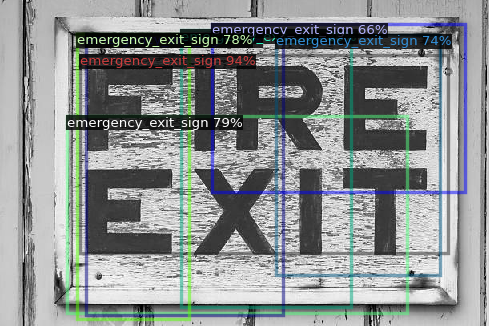

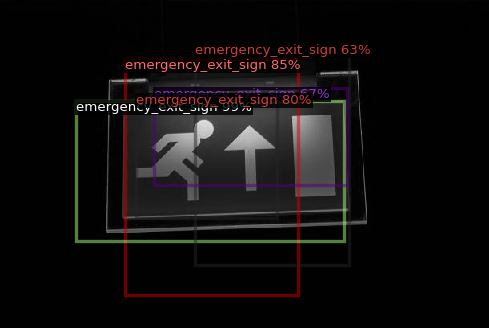

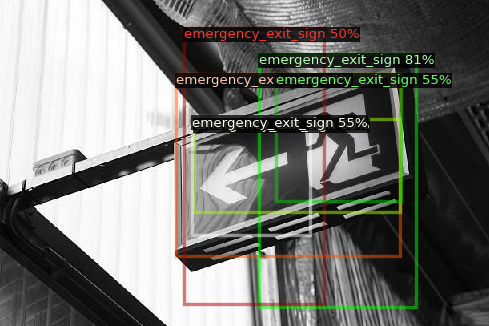

In [30]:
from detectron2.utils.visualizer import ColorMode


for d in random.sample(dataset_dicts, 3):
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=emergency_exit_sign_metadata,
                   scale=0.8,
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(v.get_image()[:, :, ::-1])

In [31]:
# Create test data directory
from pathlib import Path


data_path = Path('data/')
image_path = data_path / 'test_images'

if image_path.is_dir():
  print(f'[INFO] {image_path} already exists, skipping download...')
else:
  print(f'[INFO] Unable to find {image_path}, creating one...')
  image_path.mkdir(parents=True, exist_ok=True)

[INFO] data/test_images already exists, skipping download...


Files and directories in ' data/test_images ' :
['istockphoto-1493956694-612x612.jpg', 'output-2465607_1280.jpg', 'istockphoto-1498980232-612x612.jpg', 'shield-3116424_1280.jpg', 'istockphoto-1497657767-612x612.jpg', 'istockphoto-1493957199-612x612.jpg', 'istockphoto-1496836584-612x612.jpg', 'istockphoto-1497200961-612x612.jpg', 'shield-710184_1280.jpg', 'istockphoto-1498058359-612x612.jpg', 'leuchtkasten-1773916_1280.jpg', 'istockphoto-1501216762-612x612.jpg', 'stairs-5091557_1280.jpg']


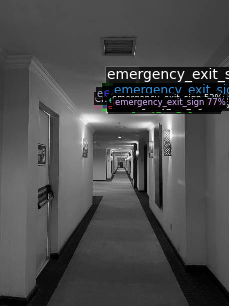

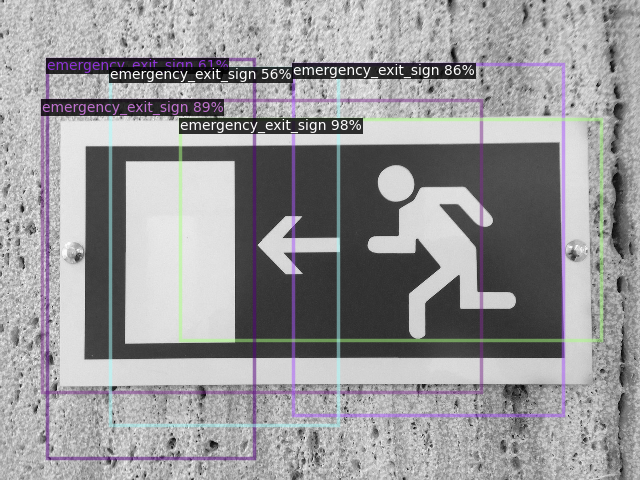

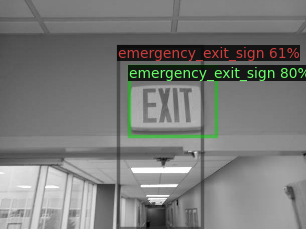

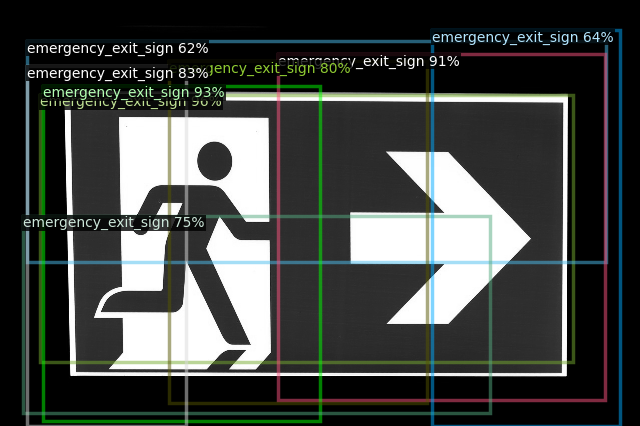

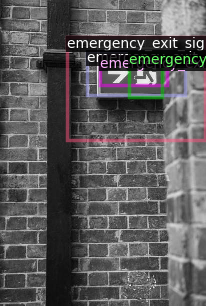

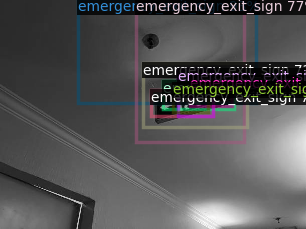

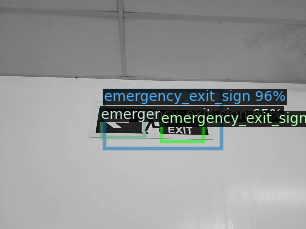

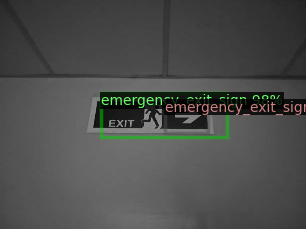

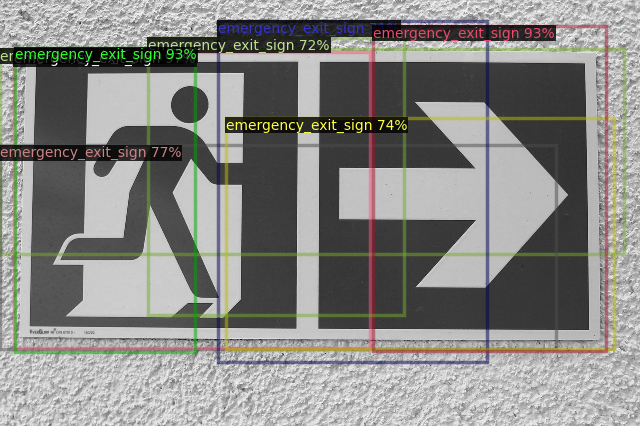

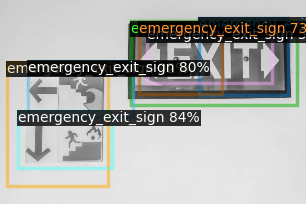

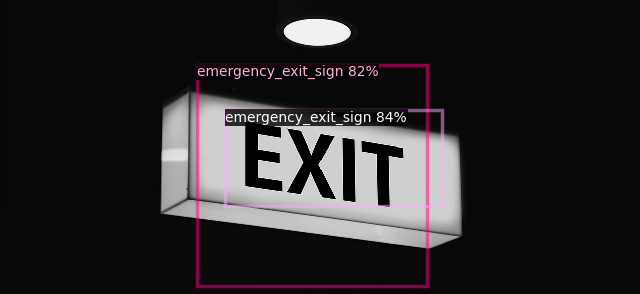

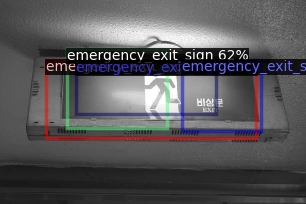

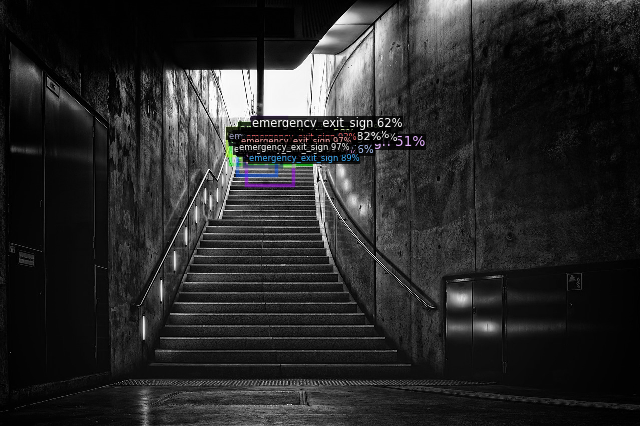

In [32]:
from detectron2.utils.visualizer import ColorMode


# import OS module
import os

# Get the list of all files and directories
test_dir_list = os.listdir(image_path)
print("Files and directories in '", image_path, "' :")
# prints all files
print(test_dir_list)

for image in test_dir_list:
    im = cv2.imread(f'./data/test_images/{image}')
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=emergency_exit_sign_metadata,
                   scale=0.5,
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(v.get_image()[:, :, ::-1])